In [1]:
import numpy as np
import pandas as pd

import mlgrad.model as model
import mlgrad.func as func
import mlgrad.irls as irls

import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper', 'seaborn-white'])
plt.matplotlib.rcParams["figure.dpi"] = 120

In [2]:
def huber_func(r, c=1):
    xs = []
    for x in r:
        x_abs = abs(x)
        if x_abs <= c:
            v = (x_abs/c)**2
        else:
            v = 2.*(x_abs/c)-1.
        xs.append(v)
    return xs

In [3]:
def tukey_func(r, c=1):
    xs = []
    for x in r:
        x_abs = abs(x)
        if x_abs <= c:
            v = 1.-(1.-(x_abs/c)**2)**3
        else:
            v = 1.
        xs.append(v)
    return xs

In [14]:
def abs_trunc(r, c=1):
    xs = []
    for x in r:
        v = abs(x) - c
        if v < 0:
            v = 0.
        xs.append(v)
    return xs

def hinge(r, c=1):
    xs = []
    for x in r:
        v = c - x
        if v < 0:
            v = 0.
        xs.append(v)
    return xs

In [5]:
def hinge2(r, c=1):
    xs = []
    for x in r:
        if x < 0:
            v = 0.5 - x/c
        elif x < 1:
            v = 1-x/c
            v = 0.5*v*v
        else:
            v = 0
        xs.append(v)
    return xs

def hinge3(r, c=1):
    xs = []
    for x in r:
        v = 1-x/c
        v = 0.5*(v + np.sqrt(v*v+1))
        xs.append(v)
    return xs

In [6]:
def logistic(r, c=1):
    xs = []
    for x in r:
        v = 1-x/c
        v = 1/(1+np.exp(-v))
        xs.append(v)
    return xs

In [7]:
def s_power(r, p):
    xs = []
    for x in r:
        if x > 0:
            v = x**p
        else:
            v = (-x)**p
        xs.append(v)
    return xs

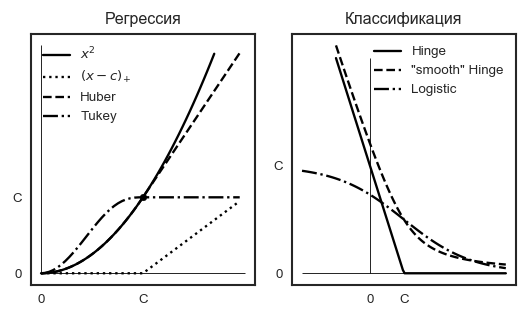

In [35]:
plt.figure(figsize=(4.5, 2.75))
range_x = np.linspace(0, 1.7, 50)
range_x2 = np.linspace(0, 1.95, 50)
plt.subplot(1,2,1)
#plt.title('Regression')
plt.title('Регрессия')
plt.plot(range_x, np.power(range_x, 2), color='k', linestyle='-', label=r'$x^2$')
plt.plot(range_x2, abs_trunc(range_x2), color='k', linestyle=':', label=r'$(x-c)_{+}$')
plt.plot(range_x2, huber_func(range_x2), color='k', linestyle='--', label=r'Huber')
plt.plot(range_x2, tukey_func(range_x2), color='k', linestyle='-.', label=r'Tukey')
plt.scatter([1], [1], c='k', s=16)
plt.xticks([0, 1], [0, 'C'])
plt.yticks([0, 1], [0, 'C'])
plt.hlines(0, 0, 2.0, linewidth=0.5)
plt.vlines(0, 0, 3.0, linewidth=0.5)
plt.legend(loc='best')
plt.subplot(1,2,2)
range_x3 = np.linspace(-2., 4., 100)
range_x4 = np.linspace(-1., 4., 100)
#plt.title('Classification')
plt.title('Классификация')
plt.plot(range_x4, hinge(range_x4), color='k', linestyle='-', label=r'Hinge')
plt.plot(range_x4, hinge3(range_x4), color='k', linestyle='--', label=r'"smooth" Hinge')
plt.plot(range_x3, logistic(range_x3), color='k', linestyle='-.', label=r'Logistic')
plt.hlines(0, -2.0, 4.0, linewidth=0.5)
plt.vlines(0, 0, 2.0, linewidth=0.5)
plt.xticks([0, 1], [0, 'C'])
plt.yticks([0, 1], [0, 'C'])
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('fig/loss_funcs.png')
plt.show()

## US Judge Ratings

In [9]:
df = pd.read_csv('data/USJudgeRatings.csv', sep='\t')

In [10]:
X = DILG = df['DILG'].values
Y = PHYS = df['PHYS'].values
Xs = X.reshape(-1,1)

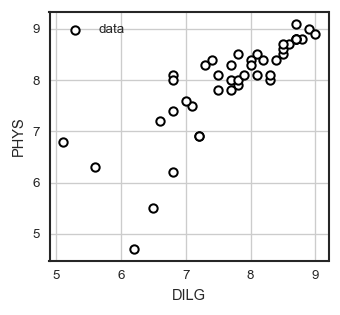

In [11]:
plt.figure(figsize=(3, 2.75))
plt.scatter(X, Y, s=25, marker='o', c='w', edgecolors='k', linewidths=1.2, label='data')
plt.grid(1)
plt.minorticks_on()
plt.legend(loc='upper left')
plt.xlabel('DILG')
plt.ylabel('PHYS')
plt.show()

In [12]:
param_init_hub = np.random.random((2,))
lm_line_hub = model.LinearModel(param_init_hub)
huber_func = func.Huber()

d = {"param":[], "K":[], "lval":[]}
def callback(alg, d=d):
    d["param"].append(alg.fg.model.param.base.copy())
    d["lval"].append(alg.fg.lval_min)
    d["K"].append(alg.fg.K)

alg_hub = irls.irls(Xs, Y, lm_line_hub, huber_func, callback=callback, h=0.01)

29 [ 1.64530284  0.81715078]


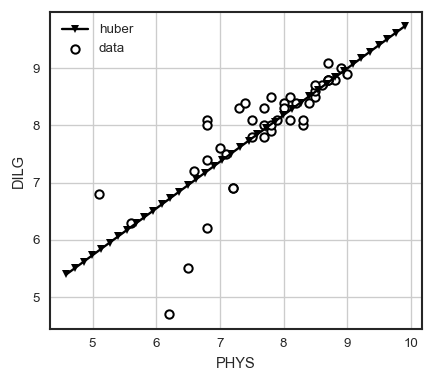

In [13]:
xrange = np.linspace(X.min()*0.9, X.max()*1.1, 40)

plt.figure(figsize=(4, 3.5))
plt.scatter(X, Y, s=25, marker='o', c='w', edgecolors='k', linewidths=1.2, label='data')
#plt.plot(xrange, rlm_results.predict(xrange), marker='o', label='huber', color='k', markersize=4)
plt.plot(xrange, lm_line_hub.evaluate_all(xrange.reshape(-1,1)), marker='v', label='huber', color='k', markersize=5)
plt.legend(loc='upper left')
plt.grid(1)
plt.minorticks_on()
plt.ylabel('DILG')
plt.xlabel('PHYS')
plt.show()

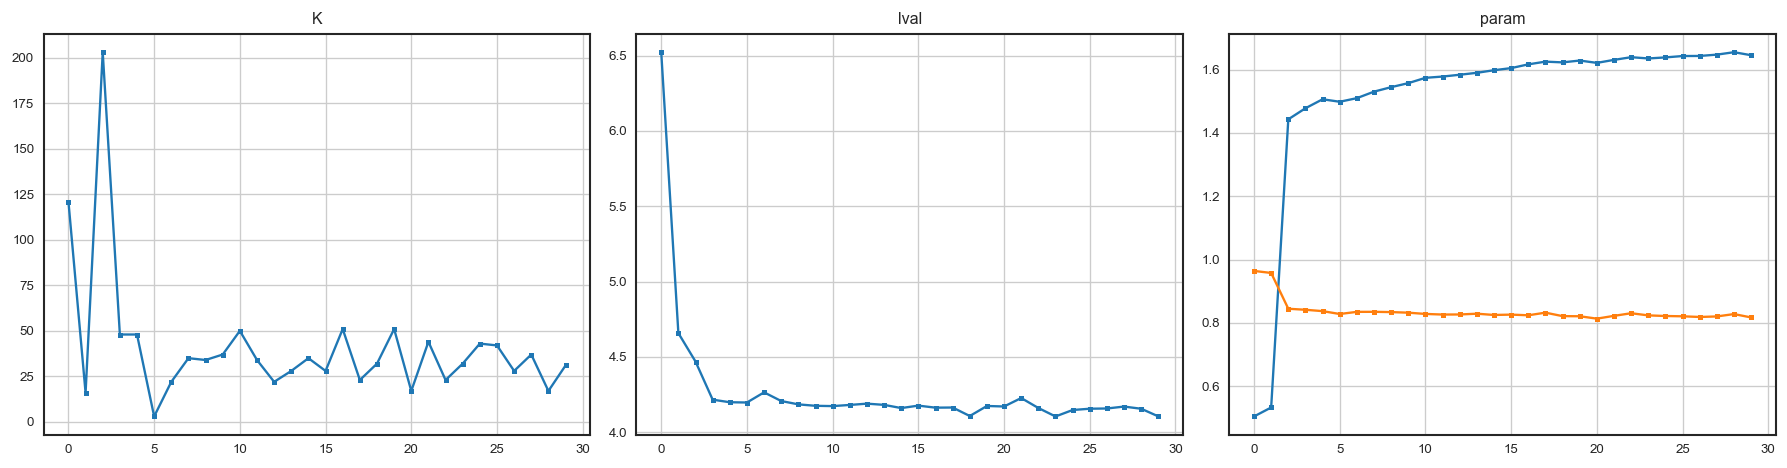

In [14]:
def plot_log(d):
    plt.figure(figsize=(15,4))
    m = len(d)
    i = 1
    for key, vals in sorted(d.items()):
        plt.subplot(1, m, i)
        k_range, u_seq = zip(*enumerate(d[key]))
        plt.plot(k_range, u_seq, marker='s', markersize=3)
        #plt.plot(k_range[-1:], np.abs(u_seq[-1:]), marker='s', markersize=8)
        plt.grid(1)
        plt.title(key)
        plt.minorticks_on()
        i += 1
        plt.tight_layout()
    plt.show()
    
plot_log(d)